# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [128]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import random as rd
import math
from sklearn.preprocessing import Imputer, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import ks_2samp
import time

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias_old=azdias.copy()
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.dtypes.value_counts()

float64    49
int64      32
object      4
dtype: int64

In [5]:
azdias.describe(include=[np.object])

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015
count,798073,792242,792242,792242
unique,2,10,45,22
top,W,8,6B,51
freq,629528,134441,56672,133694


In [6]:
azdias.describe(exclude=[np.object])

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
feat_info.head(15)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.

def replace_missing(db,descriptivedb):
    tl=list(descriptivedb.missing_or_unknown.unique())
    new_missing_or_unknown={}
    for i in tl:
        ind_list=[]
        for j in range(0,len(i[1:-1].split(','))):
            val=i[1:-1].split(',')[j].replace('"', '')
            if val in ['X','XX','']:
                ind_list.append(val)
            else:
                ind_list.append(int(val))
        new_missing_or_unknown[i]=ind_list

    mou_dict = descriptivedb.set_index('attribute')['missing_or_unknown'].to_dict()
    for key,val in mou_dict.items():
        db[key].replace(new_missing_or_unknown[val],np.nan, inplace = True)
    return db

In [9]:
azdias=replace_missing(azdias,feat_info)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
Percentage_of_Null_Per_Column_old=azdias_old.isnull().sum()
Percentage_of_Null_Per_Column_old=Percentage_of_Null_Per_Column_old.sum()/(len(azdias_old)*85)*100
print('There is {}% missing values before accounting for missing or unknown data.'.
      format(round(Percentage_of_Null_Per_Column_old,2)))

There is 6.46% missing values before accounting for missing or unknown data.


In [11]:
Percentage_of_Null_Per_Column=azdias.isnull().sum()
Percentage_of_Null_Per_Column=Percentage_of_Null_Per_Column.sum()/(len(azdias)*85)*100
print('There is {}% missing values after accounting for missing or unknown data.'.
      format(round(Percentage_of_Null_Per_Column,2)))

There is 11.05% missing values after accounting for missing or unknown data.


<a id='fig1_1'></a>

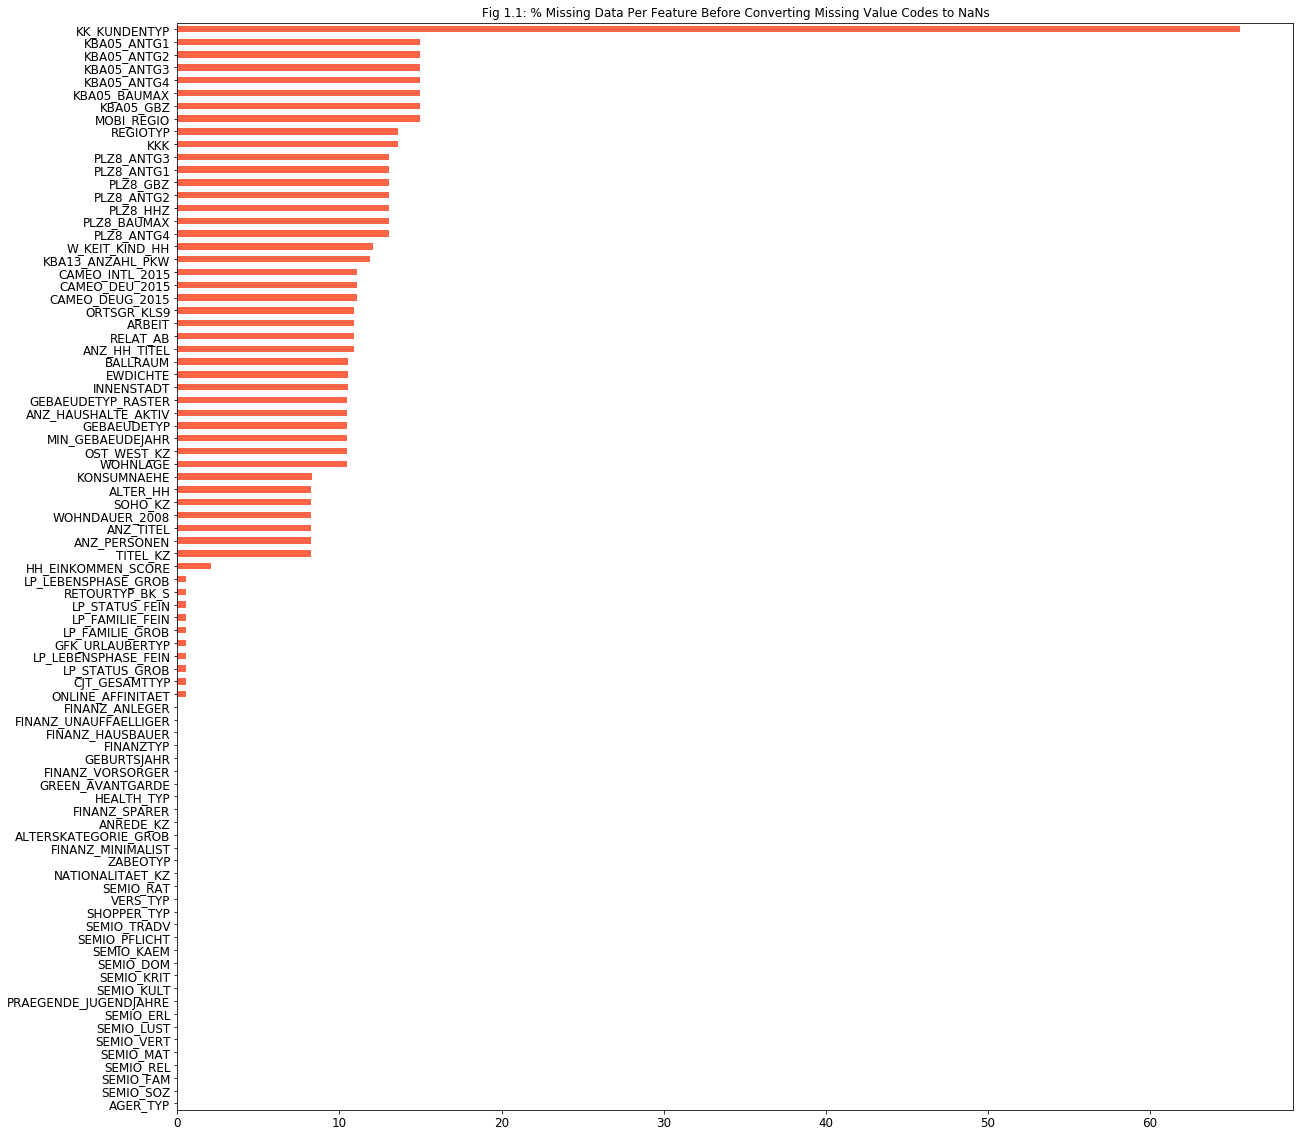

In [12]:
Percentage_of_Null_Per_Column_old=azdias_old.isnull().sum() * 100 / len(azdias_old)
Percentage_of_Null_Per_Column_old.sort_values().plot.barh(figsize=(20,20),fontsize=12,color='tomato')
plt.title('Fig 1.1: % Missing Data Per Feature Before Converting Missing Value Codes to NaNs')
plt.show()

<a id='fig1_2'></a>

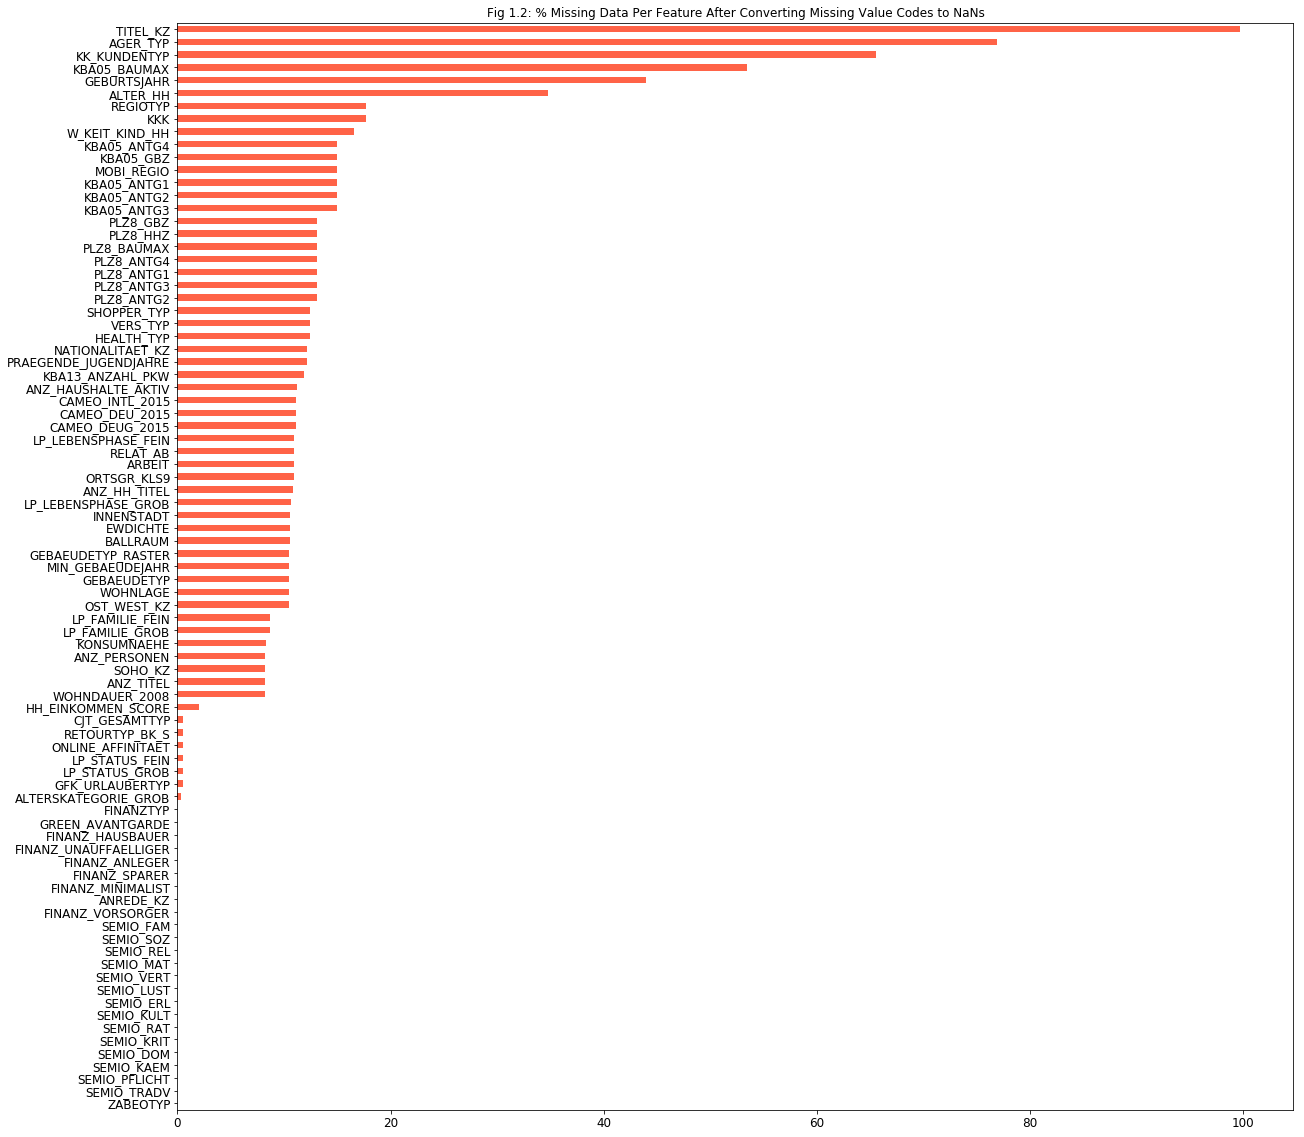

In [13]:
Percentage_of_Null_Per_Column=azdias.isnull().sum() * 100 / len(azdias)
Percentage_of_Null_Per_Column.sort_values().plot.barh(figsize=(20,20),fontsize=12,color='tomato')
plt.title('Fig 1.2: % Missing Data Per Feature After Converting Missing Value Codes to NaNs')
plt.show()

In [14]:
Percentage_of_Null_Per_Column_old=azdias_old.isnull().sum() * 100 / len(azdias_old)
Percentage_of_Null_Per_Column_old.sort_values(ascending=False)[:15]

KK_KUNDENTYP    65.596749
KBA05_ANTG1     14.959701
KBA05_ANTG2     14.959701
KBA05_ANTG3     14.959701
KBA05_ANTG4     14.959701
KBA05_BAUMAX    14.959701
KBA05_GBZ       14.959701
MOBI_REGIO      14.959701
REGIOTYP        13.598872
KKK             13.598872
PLZ8_ANTG3      13.073637
PLZ8_ANTG1      13.073637
PLZ8_GBZ        13.073637
PLZ8_ANTG2      13.073637
PLZ8_HHZ        13.073637
dtype: float64

In [15]:
Percentage_of_Null_Per_Column=azdias.isnull().sum() * 100 / len(azdias)
Percentage_of_Null_Per_Column.sort_values(ascending=False)[:15]

TITEL_KZ          99.757636
AGER_TYP          76.955435
KK_KUNDENTYP      65.596749
KBA05_BAUMAX      53.468668
GEBURTSJAHR       44.020282
ALTER_HH          34.813699
REGIOTYP          17.735668
KKK               17.735668
W_KEIT_KIND_HH    16.605084
KBA05_ANTG4       14.959701
KBA05_GBZ         14.959701
MOBI_REGIO        14.959701
KBA05_ANTG1       14.959701
KBA05_ANTG2       14.959701
KBA05_ANTG3       14.959701
dtype: float64

<a id='fig1_3'></a>

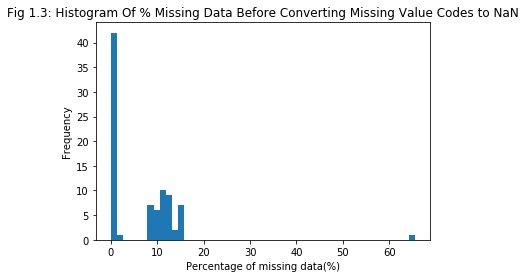

In [16]:
plt.hist(Percentage_of_Null_Per_Column_old, bins = 50)

plt.xlabel('Percentage of missing data(%)')
plt.ylabel('Frequency')
plt.title('Fig 1.3: Histogram Of % Missing Data Before Converting Missing Value Codes to NaN')
plt.show()

<a id='fig1_4'></a>

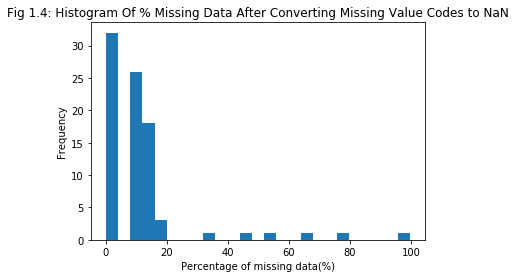

In [17]:
plt.hist(Percentage_of_Null_Per_Column, bins = 25)

plt.xlabel('Percentage of missing data(%)')
plt.ylabel('Frequency')
plt.title('Fig 1.4: Histogram Of % Missing Data After Converting Missing Value Codes to NaN')
plt.show()

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
Per_missing=Percentage_of_Null_Per_Column.to_frame().reset_index().rename(columns={'index': 'attribute', 0: 'Perc_Missing'})
Per_missing_old=Percentage_of_Null_Per_Column_old.to_frame().reset_index().rename(columns={'index': 'attribute',
                                                                                           0: 'Perc_Missing_Old'})
Per_missing=pd.merge(feat_info, Per_missing,on='attribute',how='inner')
Per_missing=pd.merge(Per_missing, Per_missing_old,on='attribute',how='inner')
Per_missing['count']=1
Per_missing['Difference']=Per_missing['Perc_Missing'] - Per_missing['Perc_Missing_Old']
Per_missing.head()

,attribute,information_level,type,missing_or_unknown,Perc_Missing,Perc_Missing_Old,count,Difference
0,AGER_TYP,person,categorical,"[-1,0]",76.955435,0.000000,1,76.955435
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]",0.323264,0.000000,1,0.323264
2,ANREDE_KZ,person,categorical,"[-1,0]",0.000000,0.000000,1,0.000000
3,CJT_GESAMTTYP,person,categorical,[0],0.544646,0.544646,1,0.000000
4,FINANZ_MINIMALIST,person,ordinal,[-1],0.000000,0.000000,1,0.000000


<a id='fig1_5'></a>

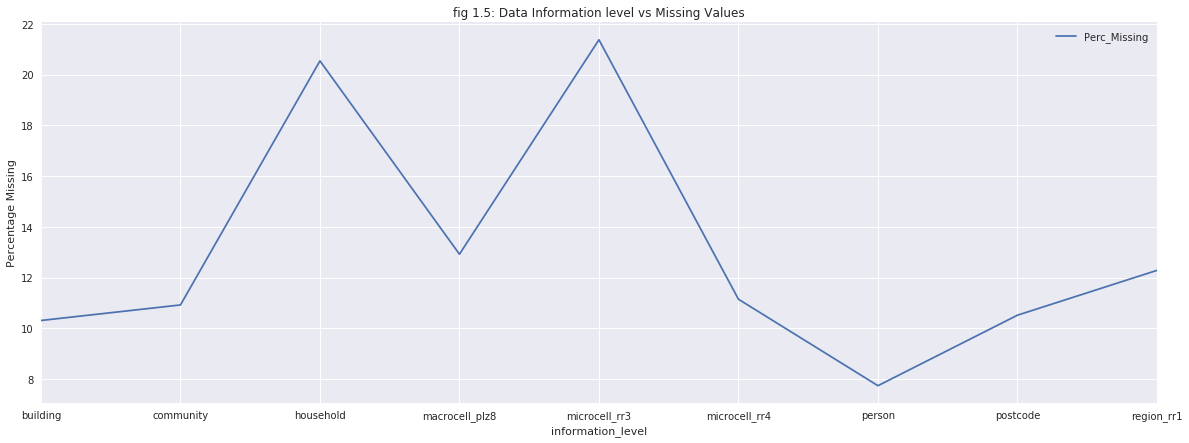

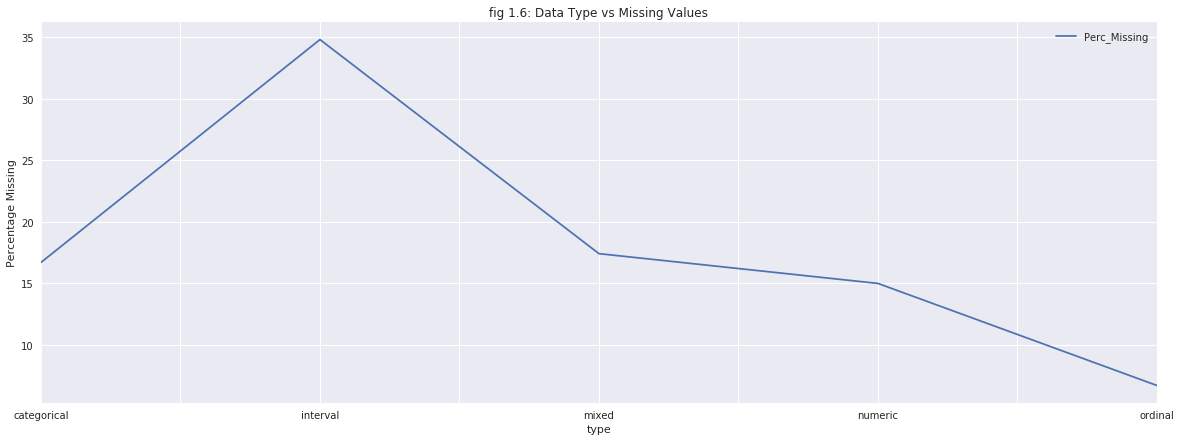

                   count
information_level       
building               7
community              3
household              7
macrocell_plz8         8
microcell_rr3          6
microcell_rr4          3
person                43
postcode               3
region_rr1             5

             count
type              
categorical     21
interval         1
mixed            7
numeric          7
ordinal         49


In [19]:
sns.set(style="darkgrid")
pd.pivot_table(Per_missing,index=["information_level"],values=["Perc_Missing"]).plot(figsize=(20, 7))
plt.ylabel('Percentage Missing')
plt.title('fig 1.5: Data Information level vs Missing Values')
pd.pivot_table(Per_missing,index=["type"],values=["Perc_Missing"]).plot(figsize=(20,7))
plt.ylabel('Percentage Missing')
plt.title('fig 1.6: Data Type vs Missing Values')
plt.show()
print(pd.pivot_table(Per_missing,index=["information_level"],values=["count"],aggfunc=np.sum))
print()
print(pd.pivot_table(Per_missing,index=["type"],values=["count"],aggfunc=np.sum))

<a id='fig1_7'></a>

,Difference
missing_or_unknown,
"[-1,0,9]",0.323264
"[-1,0]",16.034603
"[-1,9]",0.002099
"[-1,XX]",0.041853
"[-1,X]",0.041853
[-1],0.959755
[0],9.013112
[XX],0.041853
[],0.000000


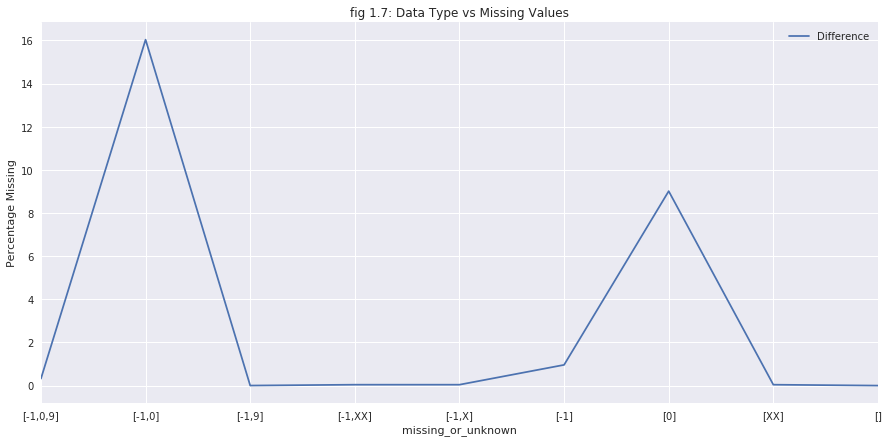

In [20]:
# Investigate patterns in the amount of missing data in each column.
pd.pivot_table(Per_missing,index=["missing_or_unknown"],values=["Difference"]).plot(figsize=(15,7))
plt.ylabel('Percentage Missing')
plt.title('fig 1.7: Data Type vs Missing Values')
pd.pivot_table(Per_missing,index=["missing_or_unknown"],values=["Difference"])

In [21]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
Col_removal_df=azdias.isnull().sum() * 100 / len(azdias)
Col_removal_df=Col_removal_df.reset_index().rename(columns={'index': 'attribute',0: 'Perc_Missing'})
Col_keepL=list(Col_removal_df.loc[Col_removal_df['Perc_Missing']<=30,:]['attribute'].values)
Col_removeL=list(Col_removal_df.loc[Col_removal_df['Perc_Missing']>30,:]['attribute'].values)
azdias=azdias[Col_keepL]
feat_info=feat_info[feat_info['attribute'].isin(Col_keepL)]
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [22]:
Col_removeL

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

#### Discussion 1.1.2: Assess Missing Data in Each Column

The first thing that can be seen is that the total % of missing data went from 6.46% to 11.05% after converting the missing value codes. One can see on [Fig 1.7](#fig1_7) the impact that each missing value codes had on our dataset. One can also have a look at [Fig 1.1](#fig1_1)vs[Fig 1.2](#fig1_2) and [Fig 1.3](#fig1_3) vs [Fig 1.4](#fig1_4) to see what difference converting missing values made on the dataset. 

After converting missing values I had a look at [Fig 1.4](#fig1_4)&[Fig 1.2](#fig1_2) and saw that one can see that there are 6 outliers that all have well above 30% missing data. These features are TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH. I'm going to remove these features since it most likely doesn't carry much information since so much data is missing.

To look at the missing data per information level one can look at [Fig 1.5](#fig1_5). It can be seen there that person data has the least amount of data missing and microcell_rr3 and household have the highest percentage missing. The other information level data is relatively the same when it comes to missing data.

To look at the missing data per data type one can look at [Fig 1.6](#fig1_5). Here it can be seen that ordinal data has the least amount of data missing and interval has the most. It is worth noting that there is only 1 interval data type in this data set. One can also see that categorical data has a fairly high amount of data missing whereas the other two datatypes are again similar.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

<a id='fig1_2_1'></a>

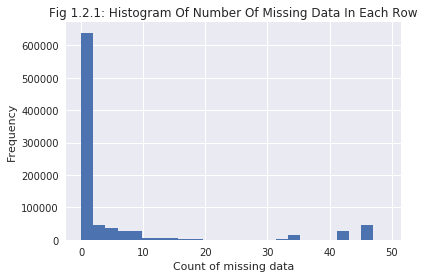

In [23]:
# How much data is missing in each row of the dataset?
Row_Missing=azdias.isnull().sum(axis=1)
plt.hist(Row_Missing, bins = 25)
plt.xlabel('Count of missing data')
plt.ylabel('Frequency')
plt.title('Fig 1.2.1: Histogram Of Number Of Missing Data In Each Row')
plt.show()

<a id='fig1_2_2'></a>

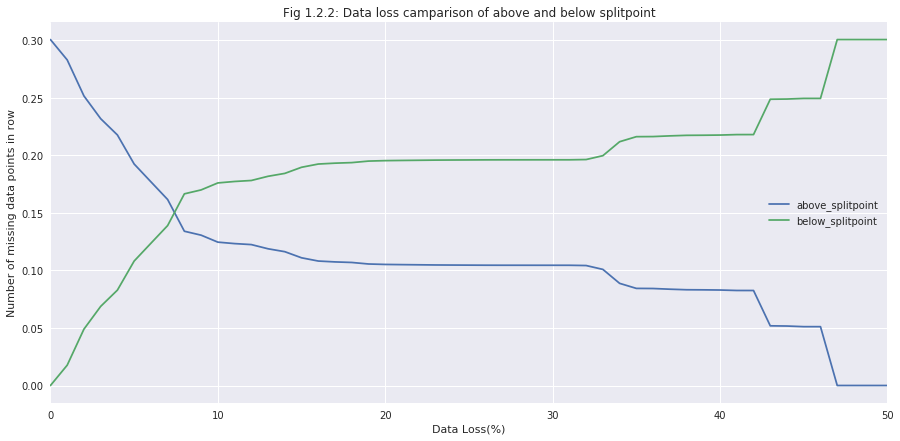

In [24]:
Row_Missing_df=pd.DataFrame(azdias.isnull().sum(axis=1))
data={'below_splitpoint':[], 'above_splitpoint':[]}
for splitpoint in range(0,51):
    data['below_splitpoint'].append(len(Row_Missing_df.loc[(Row_Missing_df[0]!=0)&(Row_Missing_df[0]<=splitpoint)])/len(azdias))
    data['above_splitpoint'].append(len(Row_Missing_df.loc[(Row_Missing_df[0]>splitpoint)])/len(azdias))
pd.DataFrame(data).plot(figsize=(15,7))
plt.xlabel('Data Loss(%)')
plt.ylabel('Number of missing data points in row')
plt.title('Fig 1.2.2: Data loss camparison of above and below splitpoint')
plt.show()

<a id='fig1_2_3'></a>

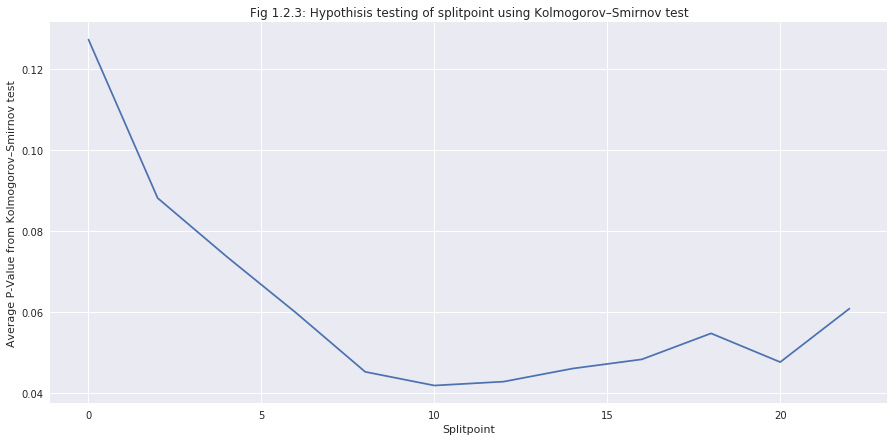

In [25]:
def hypothesis_test(df,splitpoint):
    Row_Missing_df=pd.DataFrame(df.isnull().sum(axis=1))
    below=Row_Missing_df.loc[(Row_Missing_df[0]<=splitpoint)]
    above=Row_Missing_df.loc[(Row_Missing_df[0]>splitpoint)]
    below_df=df[df.index.isin(below.index)]
    above_df=df[df.index.isin(above.index)]
    cols=list(df)
    stats = []
    pvalues = []
    for col in cols:
        counts_main = below_df[col].value_counts().sort_index()
        counts_drop = above_df[col].value_counts().sort_index()
        try:
            ch = ks_2samp(counts_main, counts_drop)
            stats.append(ch.statistic)
            pvalues.append(ch.pvalue)
        except:
            stats.append(np.nan)
            pvalues.append(np.nan)

    return stats, pvalues
max_p_test={'Splitpoint':[],'Pvals':[],'Stats':[]}
for i in range(0,23,2):
    stats, pvalues = hypothesis_test(azdias,i)
    max_p_test['Splitpoint'].append(i)
    max_p_test['Pvals'].append(np.mean(pvalues))
    max_p_test['Stats'].append(np.mean(stats))
ptest_df=pd.DataFrame.from_dict(max_p_test)
plt.figure(figsize=(15,7))
plt.plot(ptest_df["Splitpoint"], ptest_df["Pvals"])
plt.xlabel('Splitpoint')
plt.ylabel('Average P-Value from Kolmogorov–Smirnov test')
plt.title('Fig 1.2.3: Hypothisis testing of splitpoint using Kolmogorov–Smirnov test')
plt.show()

In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
def showComparison(df,splitpoint,featureName,i, secondary_splitpoint=False):
    Row_Missing_df=pd.DataFrame(df.isnull().sum(axis=1))
    if secondary_splitpoint == False:
        below=Row_Missing_df.loc[(Row_Missing_df[0]<=splitpoint)]
        above=Row_Missing_df.loc[(Row_Missing_df[0]>splitpoint)]
    else:
        below=Row_Missing_df.loc[(Row_Missing_df[0]==0)]
        above=Row_Missing_df.loc[(Row_Missing_df[0]!=0)&(Row_Missing_df[0]<=splitpoint)]
        
    fig, (ax0,ax1) = plt.subplots(1, 2,  figsize=(15, 5))
    sns.countplot(x=featureName, data=df.iloc[below.index,:],ax=ax0)
    ax0.set_title('Less than splitpoint')
    sns.countplot(x=featureName, data=df.iloc[above.index,:],ax=ax1)
    ax1.set_title('More than splitpoint')
    plt.suptitle('Fig 1.2.'+str(i))

In [27]:
PercMissingCoL=pd.DataFrame(azdias.isnull().sum() * 100 / len(azdias))
PercMissingCoL=list(PercMissingCoL.loc[PercMissingCoL[0]<=0,:].index)
PercMissingCoL=rd.sample(PercMissingCoL, 8)
PercMissingCoL

['FINANZ_UNAUFFAELLIGER',
 'SEMIO_PFLICHT',
 'SEMIO_LUST',
 'SEMIO_KULT',
 'SEMIO_VERT',
 'SEMIO_KAEM',
 'SEMIO_RAT',
 'SEMIO_SOZ']

<a id='fig1_2_4to11'></a>

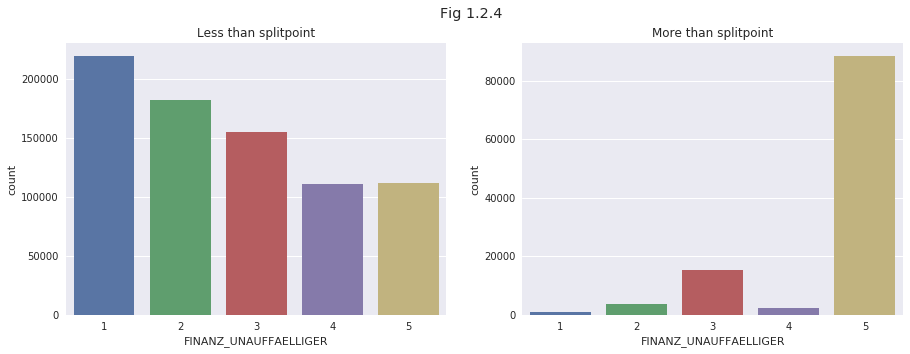

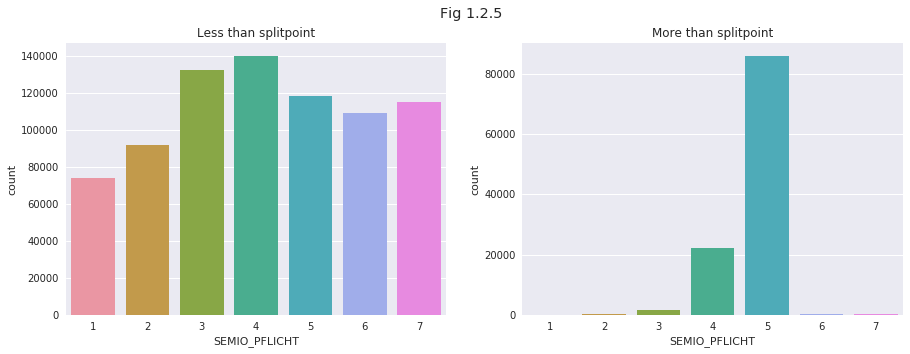

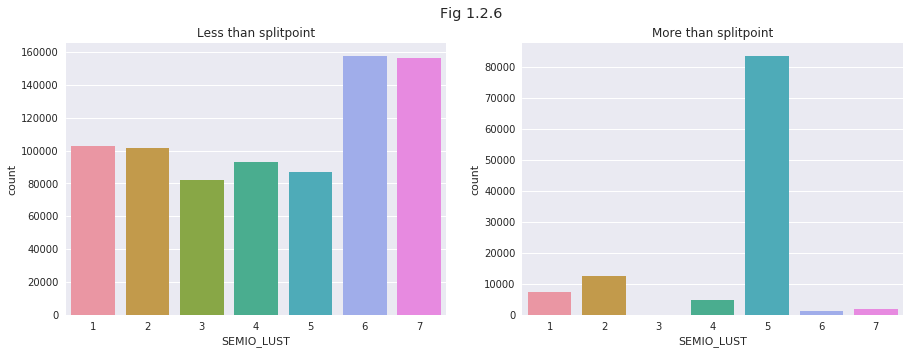

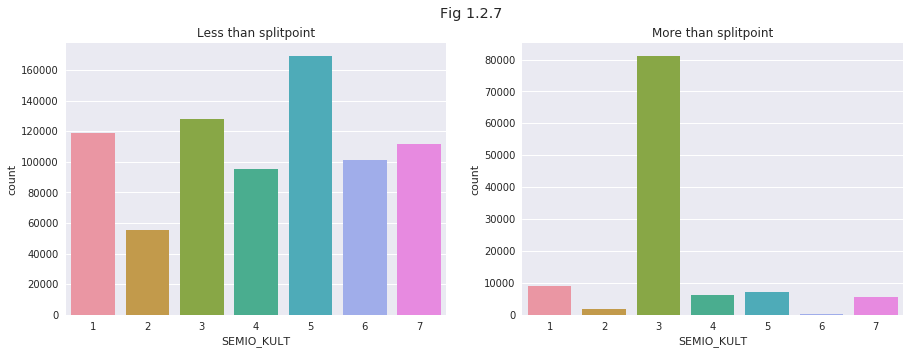

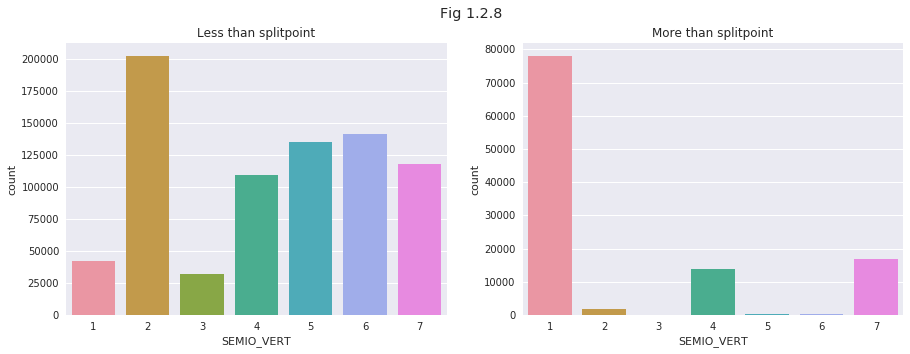

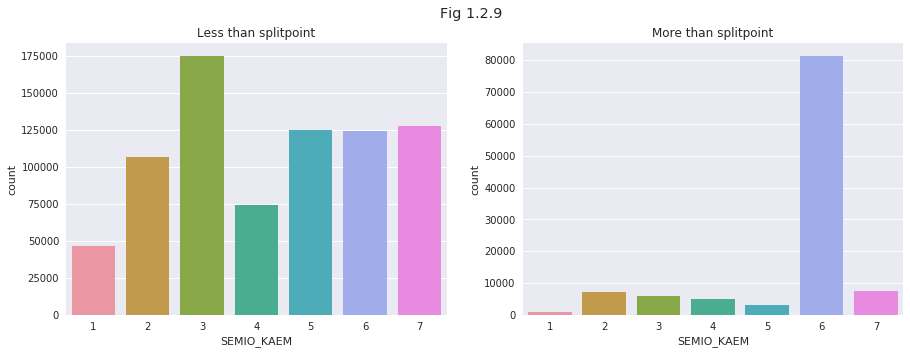

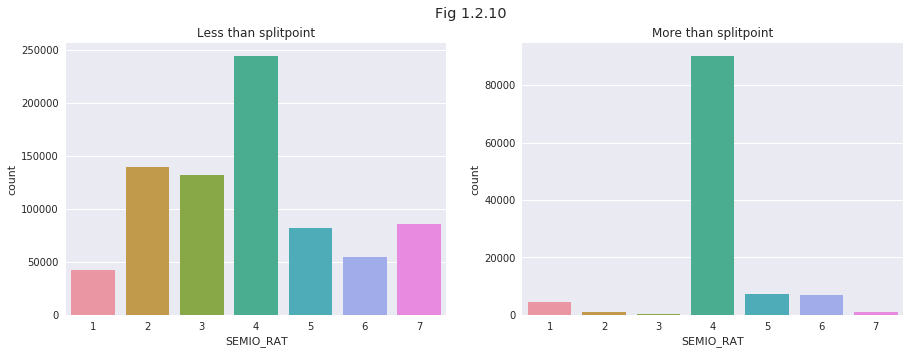

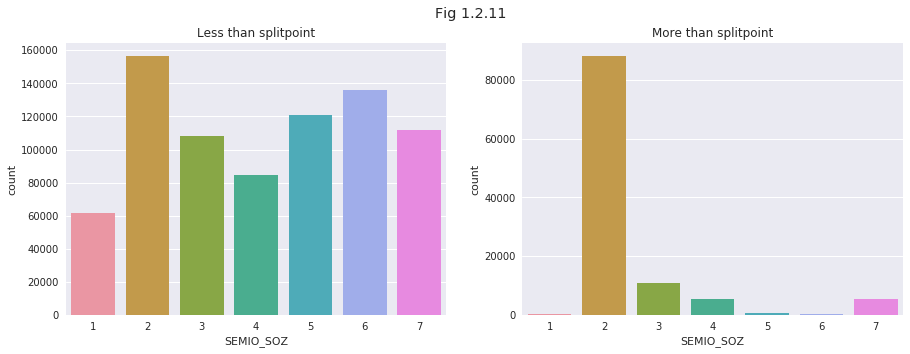

In [28]:
# here I compare data above and below the splitpoint 10
for i in range(len(PercMissingCoL)):
    showComparison(azdias,10,PercMissingCoL[i],i+4)

<a id='fig1_2_12to19'></a>

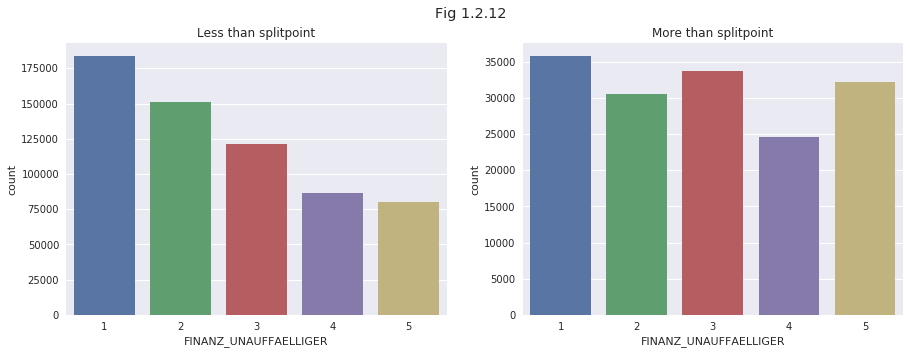

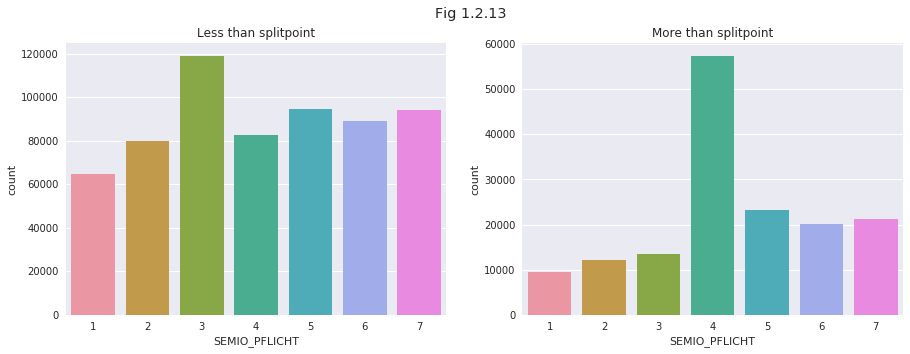

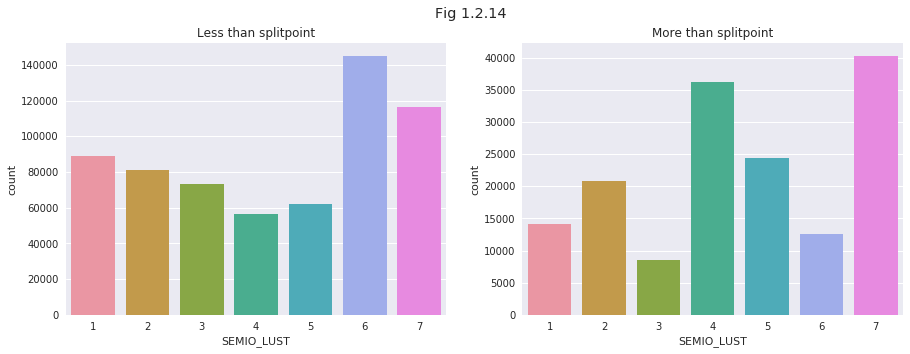

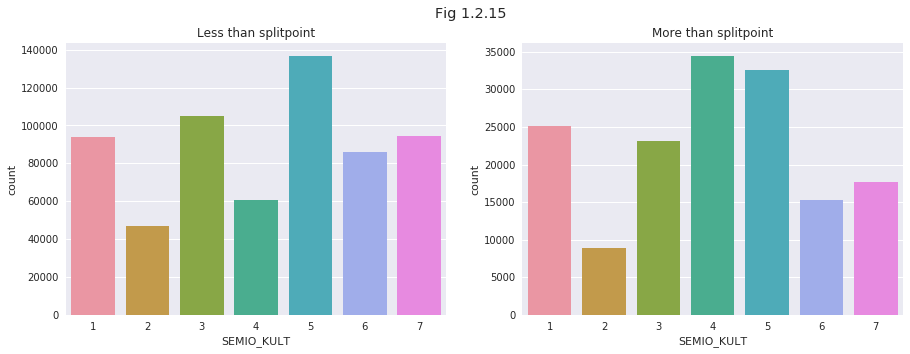

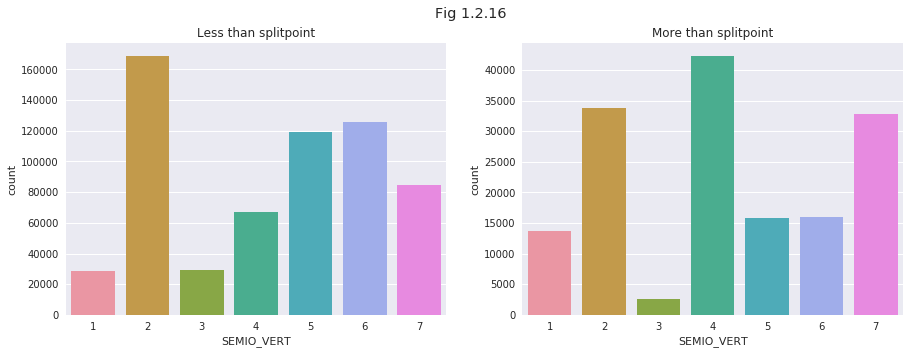

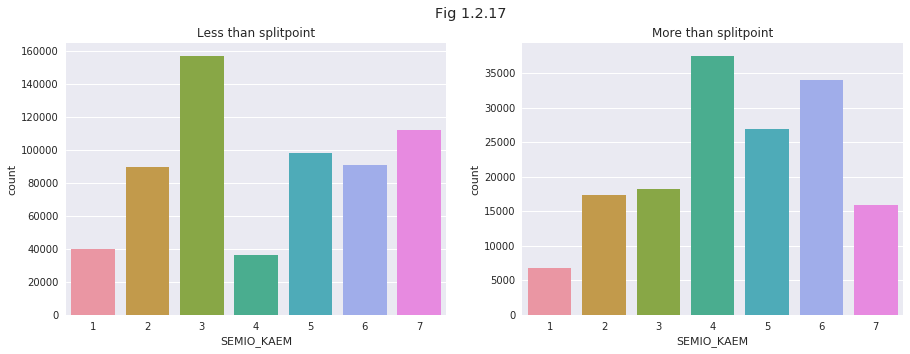

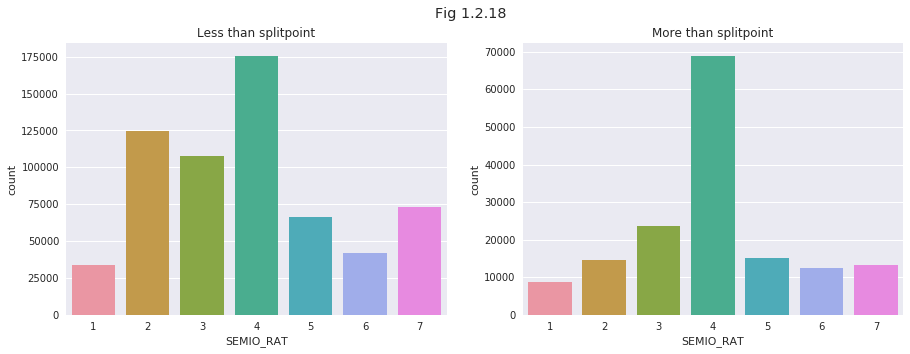

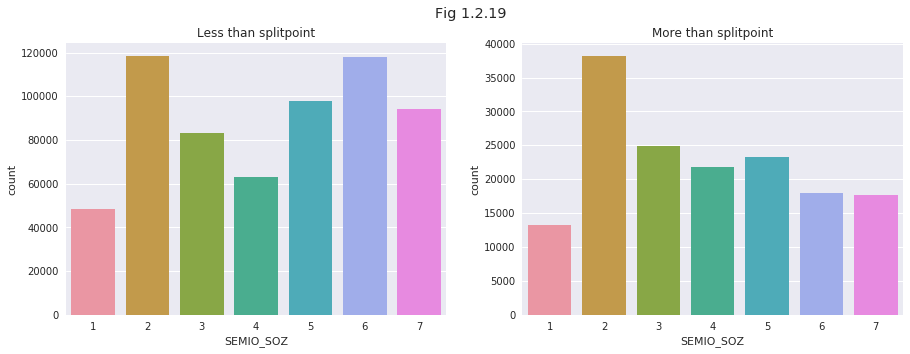

In [29]:
# here I compare data where there are no missing values in rows vs data where there are 1 to 10 missing datapoints
for i in range(len(PercMissingCoL)):
    showComparison(azdias,10,PercMissingCoL[i],i+12,True)

In [30]:
# Drop rows above splitpoint
splitpoint=10
Row_Missing_df=pd.DataFrame(azdias.isnull().sum(axis=1))
below=Row_Missing_df.loc[(Row_Missing_df[0]<=splitpoint)]
azdias=azdias[azdias.index.isin(below.index)]

#### Discussion 1.1.3: Assess Missing Data in Each Row

For the first part of my analysis, I focussed on where to make the splitpoint. This is very important since this will primarily determine if I'm going to drop some rows and how much of them I should drop if I choose to do so. Since K-means require that there is no missing data in the dataset, one will have to impute the missing data which will impact the data and take away some of the descriptiveness of the dataset. It can also be said that remove a part of the dataset would also decrease the amount of info we pass the K-means and will, therefore, lead to less accurate clusters. 

Here I think the primary objective should be to try and minimize the amount of imputation since I think that would likely have a bigger effect on k-means. The secondary objective is to minimize the amount of data dropped when minimizing the imputation done. To make my decision I used [Fig 1.2.1](#fig1_2_1) ,[Fig 1.2.2](#fig1_2_2) and [Fig 1.2.3](#fig1_2_3). On Fig 1.2.1 we can see that there is clearly a split when comparing missing data in rows with frequency. 

To find the best possible split, I used Kolmogorov–Smirnov test. The lower the p-value of this test is, the more we can assume that the two values is different. When looking at graph [Fig 1.2.3](#fig1_2_3), we can see that the splitpoint 10 has the lowest p-value that is also below 0.05 which signifies that there is a statistically significant differnece between the dataset below and above the splitpoint. I'm picking the splitpoint with the minimum p-value, because I'm using a mean of pvalues for all the features. To see the amount of dataloss if one where to remove data above the splitpoint 10, one can look at [Fig 1.2.2](#fig1_2_2). Here we can see that the dataloss would be roughly 13%, if we where to do so.

Another consideration one should make is to look at the difference in data spread between the data below and above the splitpoint. This will show us if the data above the splitpoint could hold some information that the data below the splitpoint doesn't. One can look at [Figs 1.2.4 to 1.2.11](#fig1_2_4to11) to see if the data spread is indeed different. One can clearly see that the spread does indeed look very different. This would normally tell us that we should consider keeping this data. In this case, I think it is more important to minimize imputation and would still want to drop the data above the splitpoint. To make sure that at least some of that different spread is portrayed in the dataset I used [Figs 1.2.12 to 1.2.19](#fig1_2_12to19) to compare the rows where there is no missing data to where there are between 1 and 10 missing data points. Here one can see that the spread does in fact look different and this help support the choice of dropping the data above the splitpoint.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [31]:
# How many features are there of each data type?
feat_info['count']=1
pd.pivot_table(feat_info,index=["type"],values=["count"],aggfunc=np.sum)

,count
type,
categorical,18
mixed,6
numeric,6
ordinal,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [32]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

In [33]:
cat_feat=feat_info.loc[feat_info.type=='categorical'].attribute.values

In [34]:
cat_types=[]
for i in cat_feat:
    uniquevals=azdias[i].unique()
    cleanedList = [x for x in uniquevals if str(x) != 'nan']
    cat_types.append([i,list(cleanedList),uniquevals.dtype.kind])
print(cat_types)

[['ANREDE_KZ', [2, 1], 'i'], ['CJT_GESAMTTYP', [5.0, 3.0, 2.0, 4.0, 1.0, 6.0], 'f'], ['FINANZTYP', [1, 6, 5, 2, 4, 3], 'i'], ['GFK_URLAUBERTYP', [10.0, 1.0, 5.0, 12.0, 9.0, 3.0, 8.0, 11.0, 4.0, 7.0, 2.0, 6.0], 'f'], ['GREEN_AVANTGARDE', [0, 1], 'i'], ['LP_FAMILIE_FEIN', [5.0, 1.0, 10.0, 2.0, 7.0, 11.0, 8.0, 4.0, 6.0, 9.0, 3.0], 'f'], ['LP_FAMILIE_GROB', [3.0, 1.0, 5.0, 2.0, 4.0], 'f'], ['LP_STATUS_FEIN', [2.0, 3.0, 9.0, 4.0, 1.0, 10.0, 5.0, 8.0, 6.0, 7.0], 'f'], ['LP_STATUS_GROB', [1.0, 2.0, 4.0, 5.0, 3.0], 'f'], ['NATIONALITAET_KZ', [1.0, 3.0, 2.0], 'f'], ['SHOPPER_TYP', [3.0, 2.0, 1.0, 0.0], 'f'], ['SOHO_KZ', [1.0, 0.0], 'f'], ['VERS_TYP', [2.0, 1.0], 'f'], ['ZABEOTYP', [5, 3, 4, 1, 6, 2], 'i'], ['GEBAEUDETYP', [8.0, 1.0, 3.0, 2.0, 6.0, 4.0, 5.0], 'f'], ['OST_WEST_KZ', ['W', 'O'], 'O'], ['CAMEO_DEUG_2015', ['8', '4', '2', '6', '1', '9', '5', '7', '3'], 'O'], ['CAMEO_DEU_2015', ['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D',

In [35]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Binary - I'm only reencoding OST_WEST_KZ
try:
    azdias['OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace = True)
except:
    pass

# multi-levels 
change_dict={}
for i in cat_types:
    if i[-1]!='O':
        if i[-1]=='f':
            if len(i[1])>2:
                change_dict[i[0]]={}
                for j in range(0,len(i[1])):
                    change_dict[i[0]][i[1][j]]=str(int(i[1][j]))
        else:
            if len(i[1])>2:
                change_dict[i[0]]={}
                for j in range(0,len(i[1])):
                    change_dict[i[0]][i[1][j]]=str(i[1][j])
    else:
        change_dict[i[0]]={}
for i in [*change_dict]:
    azdias[i].replace(change_dict[i], inplace = True)

In [36]:
# One hot encode multi-levels 
change_dictlist=[*change_dict]
do_not_Encode=['CAMEO_DEU_2015','ANREDE_KZ','OST_WEST_KZ','VERS_TYP','GREEN_AVANTGARDE','SOHO_KZ']
change_dictlist=[x for x in change_dictlist if x not in do_not_Encode]
azdias=pd.get_dummies(azdias, columns=change_dictlist, dummy_na = False)

#### Discussion 1.2.1: Re-Encode Categorical Features

##### multi-levels: 
We can see that CAMEO_DEU_2015 has a big range of features so I'm going to drop that feature. I have chosen to One hot encoded the rest of the categorical features.

##### Binary - I'm only re-encoding
I only reencoded OST_WEST_KZ for the binary categorical features since it had strings instead of integers. I didn't have to do anything with the rest of the Binary values since they are already numbers.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [37]:
mixed_feat=feat_info.loc[feat_info.type=='mixed'].attribute.values
pd.pivot_table(feat_info,index=["type"],values=["count"],aggfunc=np.sum)

,count
type,
categorical,18
mixed,6
numeric,6
ordinal,49


In [38]:
azdias[mixed_feat].dtypes

LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
PRAEGENDE_JUGENDJAHRE    float64
WOHNLAGE                 float64
CAMEO_INTL_2015           object
PLZ8_BAUMAX              float64
dtype: object

In [39]:
azdias['CAMEO_INTL_2015']=azdias['CAMEO_INTL_2015'].convert_objects(convert_numeric=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [40]:
azdias[mixed_feat].dtypes

LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
PRAEGENDE_JUGENDJAHRE    float64
WOHNLAGE                 float64
CAMEO_INTL_2015          float64
PLZ8_BAUMAX              float64
dtype: object

<a id='fig1_2_2_1'></a>

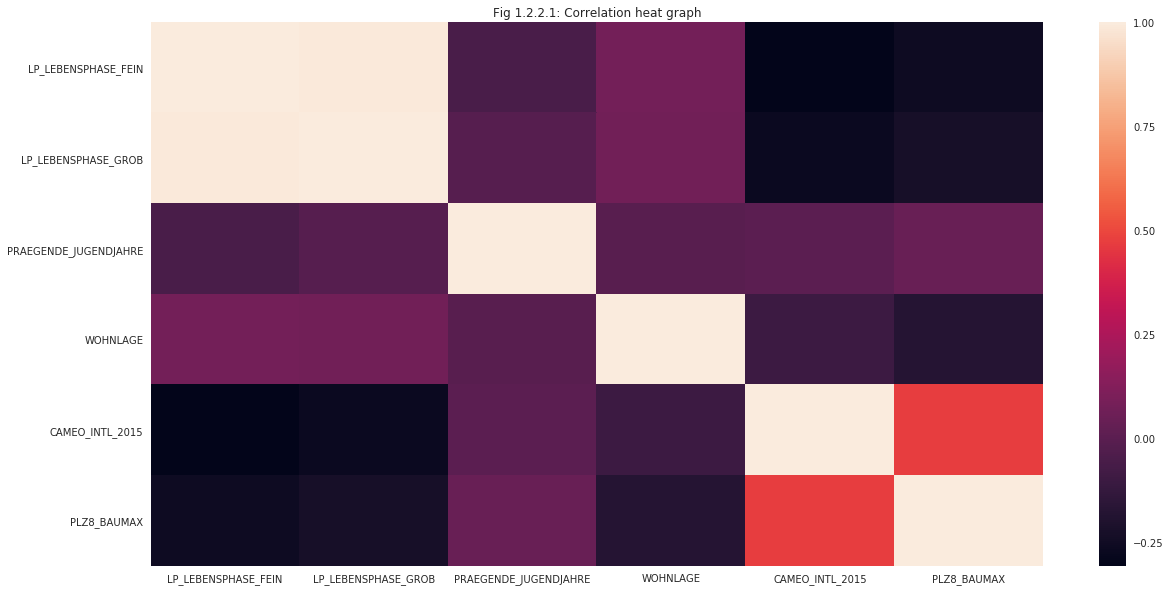

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,PLZ8_BAUMAX
LP_LEBENSPHASE_FEIN,1.000000,0.990156,-0.051513,0.077283,-0.306291,-0.260133
LP_LEBENSPHASE_GROB,0.990156,1.000000,-0.013944,0.072108,-0.270353,-0.226216
PRAEGENDE_JUGENDJAHRE,-0.051513,-0.013944,1.000000,-0.007091,-0.000074,0.045482
WOHNLAGE,0.077283,0.072108,-0.007091,1.000000,-0.100536,-0.174205
CAMEO_INTL_2015,-0.306291,-0.270353,-0.000074,-0.100536,1.000000,0.469932
PLZ8_BAUMAX,-0.260133,-0.226216,0.045482,-0.174205,0.469932,1.000000


In [41]:
# calculate the correlation matrix
corr=azdias[mixed_feat].corr()

# plot the heatmap
plt.figure(figsize=(20,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.title('Fig 1.2.2.1: Correlation heat graph')
plt.show()
corr

In [42]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
'''
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)'''

# create MOVEMENT variable: 1:Mainstream, 2:Avantgarde
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'MOVEMENT']=1
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'MOVEMENT']=2

# create NATION varibale: 1:E, 2:W, 3:E+W
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13]),'NATION']=1
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11]),'NATION']=2
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15]),'NATION']=3


In [43]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
'''German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown'''

# create WEALTH variable
azdias['WEALTH'] = pd.to_numeric(azdias['CAMEO_INTL_2015'])//10

# create LIFE_STAGE variable
azdias['LIFE_STAGE'] = pd.to_numeric(azdias['CAMEO_INTL_2015'])%10

In [44]:
'''
WOHNLAGE:
Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood'''

# create RURAL variable
azdias.loc[azdias['WOHNLAGE'].isin([7,8]),'RURAL']=1
azdias.loc[azdias['WOHNLAGE'].isin([0,1,2,3,4,5,6]),'RURAL']=0

# Replcae 7&8 as none values in WOHNLAGE
azdias['WOHNLAGE'].replace({7:np.nan, 8:np.nan}, inplace = True)


#### Discussion 1.2.2: Engineer Mixed-Type Features

For the mixed types, I only decided to re-encode PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015 and WOHNLAGE. In order to decide which of the mixed features I should keep, I used [Fig 1.2.2.1](#fig1_2_2_1). Here you can see that CAMEO_INTL_2015 has a very high correlation with LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB and PLZ8_BAUMAX. I chose to drop these three features since their correlation with CAMEO_INTL_2015 was too high.

I split PRAEGENDE_JUGENDJAHRE into to variables namely Movement and NATION. I also split CAMEO_INTL_2015 into two variables namely WEALTH and LIFE_STAGE. For WOHNLAGE I first created a new feature to represent a binary value for rural neighberhood. So I made 7&8 as 1 and the rest as 0 in this new feature. Then I replaced 7&8 in the WOHNLAGE feature as nan values, to later be imputed.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [45]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [46]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#drop CAMEO_DEU_2015
azdias=azdias.drop('CAMEO_DEU_2015',errors='ignore', axis=1)

#drop CAMEO_DEU_2015
azdias=azdias.drop('PRAEGENDE_JUGENDJAHRE',errors='ignore', axis=1)

#drop CAMEO_DEU_2015
azdias=azdias.drop('CAMEO_INTL_2015',errors='ignore', axis=1)

#drop LP_LEBENSPHASE_FEIN
azdias=azdias.drop('LP_LEBENSPHASE_FEIN',errors='ignore', axis=1)

#drop LP_LEBENSPHASE_GROB
azdias=azdias.drop('LP_LEBENSPHASE_GROB',errors='ignore', axis=1)

#drop PLZ8_BAUMAX
azdias=azdias.drop('PLZ8_BAUMAX',errors='ignore', axis=1)



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [199]:
def clean_data(df,feat_disc,dontRemoveList):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df = replace_missing(df,feat_disc)
    # remove selected columns and rows, ...
    df=df[dontRemoveList]
    feat_disc=feat_disc[feat_disc['attribute'].isin(dontRemoveList)]
    
    # Drop rows above splitpoint 
    splitpoint=10
    NRow_Missing_df=pd.DataFrame(df.isnull().sum(axis=1))
    below=NRow_Missing_df.loc[(NRow_Missing_df[0]<=splitpoint)]
    df=df[df.index.isin(below.index)]

    # select, re-encode, and engineer column values.
    cat_feat1=feat_disc.loc[feat_disc.type=='categorical'].attribute.values
    
    cat_types1=[]
    for i in cat_feat1:
        uniquevals1=df[i].unique()
        cleanedList1 = [x for x in uniquevals1 if str(x) != 'nan']
        cat_types1.append([i,list(cleanedList1),uniquevals1.dtype.kind])

    # Binary - I'm only reencoding OST_WEST_KZ
    try:
        df['OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace = True)
    except:
        pass

    # multi-levels 
    change_dict1={}
    for i in cat_types1:
        if i[-1]!='O':
            if i[-1]=='f':
                if len(i[1])>2:
                    change_dict1[i[0]]={}
                    for j in range(0,len(i[1])):
                        change_dict1[i[0]][i[1][j]]=str(int(i[1][j]))
            else:
                if len(i[1])>2:
                    change_dict1[i[0]]={}
                    for j in range(0,len(i[1])):
                        change_dict1[i[0]][i[1][j]]=str(i[1][j])
        else:
            change_dict1[i[0]]={}
    for i in [*change_dict1]:
        df[i].replace(change_dict1[i], inplace = True)
        
    change_dictlist1=[*change_dict1]
    do_not_Encode=['CAMEO_DEU_2015','ANREDE_KZ','OST_WEST_KZ','VERS_TYP','GREEN_AVANTGARDE','SOHO_KZ']
    change_dictlist1=[x for x in change_dictlist1 if x not in do_not_Encode]
    df=pd.get_dummies(df, columns=change_dictlist1, dummy_na = False)
    
    # One hot encode multi-levels 
    
    # create MOVEMENT variable: 1:Mainstream, 2:Avantgarde
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'MOVEMENT']=1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'MOVEMENT']=2

    # create NATION varibale: 1:E, 2:W, 3:E+W
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13]),'NATION']=1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11]),'NATION']=2
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15]),'NATION']=3

    # create WEALTH variable
    df['WEALTH'] = pd.to_numeric(df['CAMEO_INTL_2015'])//10

    # create LIFE_STAGE variable
    df['LIFE_STAGE'] = pd.to_numeric(df['CAMEO_INTL_2015'])%10

    # create RURAL variable
    df.loc[df['WOHNLAGE'].isin([7,8]),'RURAL']=1
    df.loc[df['WOHNLAGE'].isin([0,1,2,3,4,5,6]),'RURAL']=0

    # Replcae 7&8 as none values in WOHNLAGE
    df['WOHNLAGE'].replace({7:np.nan, 8:np.nan}, inplace = True)
    
    # drop CAMEO_DEU_2015
    df=df.drop('CAMEO_DEU_2015',errors='ignore', axis=1)

    # drop CAMEO_DEU_2015
    df=df.drop('PRAEGENDE_JUGENDJAHRE',errors='ignore', axis=1)

    # drop CAMEO_INTL_2015
    df=df.drop('CAMEO_INTL_2015',errors='ignore', axis=1)

    #drop LP_LEBENSPHASE_FEIN
    df=df.drop('LP_LEBENSPHASE_FEIN',errors='ignore', axis=1)

    #drop LP_LEBENSPHASE_GROB
    df=df.drop('LP_LEBENSPHASE_GROB',errors='ignore', axis=1)

    #drop PLZ8_BAUMAX
    df=df.drop('PLZ8_BAUMAX',errors='ignore', axis=1)
    
    # Return the cleaned dataframe.
    return df,feat_disc
    
    

In [48]:
azdias_new=azdias.copy()

In [49]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')
azdias_t=azdias.copy()
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')
feat_info_t=feat_info.copy()

In [62]:
azdias,feat_info=clean_data(azdias_t,feat_info_t,Col_keepL)

In [57]:
azdias_new.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MOVEMENT,NATION,WEALTH,LIFE_STAGE,RURAL
count,777528.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,745629.000000,...,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,753679.000000,753679.000000,776497.000000,776497.000000,780153.000000
mean,2.797778,1.521235,3.050657,2.711548,3.439027,2.838339,2.634099,3.144031,0.220073,2.203840,...,0.068448,0.133764,0.098438,0.170945,0.137537,1.227804,2.719830,3.274299,2.870714,0.233477
std,1.019078,0.499549,1.378001,1.486898,1.376730,1.473251,1.393676,1.398751,0.414296,0.755139,...,0.252513,0.340398,0.297907,0.376461,0.344414,0.419416,0.539193,1.465495,1.487881,0.423044
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,2.000000,1.000000,0.000000
50%,3.000000,2.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,4.000000,3.000000,0.000000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,5.000000,4.000000,0.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,5.000000,5.000000,1.000000


In [63]:
azdias.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MOVEMENT,NATION,WEALTH,LIFE_STAGE,RURAL
count,777528.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,745629.000000,...,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,753679.000000,753679.000000,776497.000000,776497.000000,598005.0
mean,2.797778,1.521235,3.050657,2.711548,3.439027,2.838339,2.634099,3.144031,0.220073,2.203840,...,0.068448,0.133764,0.098438,0.170945,0.137537,1.227804,2.719830,3.274299,2.870714,0.0
std,1.019078,0.499549,1.378001,1.486898,1.376730,1.473251,1.393676,1.398751,0.414296,0.755139,...,0.252513,0.340398,0.297907,0.376461,0.344414,0.419416,0.539193,1.465495,1.487881,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0
25%,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,2.000000,1.000000,0.0
50%,3.000000,2.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,4.000000,3.000000,0.0
75%,4.000000,2.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,5.000000,4.000000,0.0
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,5.000000,5.000000,0.0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [67]:
# Get a dataframe with no missing values
MissingRow_df=pd.DataFrame(azdias.isnull().sum(axis=1))
NoMissing=MissingRow_df.loc[(MissingRow_df[0]==0)]
azdias_NoMissing=azdias[azdias.index.isin(NoMissing.index)]

In [71]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
feature_names=list(azdias)
imputer = Imputer()
imputer_model = imputer.fit(azdias)
azdias_imputed = pd.DataFrame(imputer_model.transform(azdias), columns = feature_names)

In [61]:
# Apply feature scaling to the general population demographics data.
scalar = RobustScaler()
scalar_model = scalar.fit(azdias_NoMissing)
azdias_scaled = pd.DataFrame(scalar_model.transform(azdias_imputed), columns = feature_names)


### Discussion 2.1: Apply Feature Scaling

Here I first removed all the rows with missing data and computed the scaler. For the scaler I used the RobustScaler since it is more robust to outliers than the standard scaler. After this I imputed the missing values and then I scaled the whole dataset using computed scaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [92]:
# Apply PCA to the data.
pca = PCA()
pca_model= pca.fit(azdias_scaled)
azdias_pca = pca_model.transform(azdias_scaled)

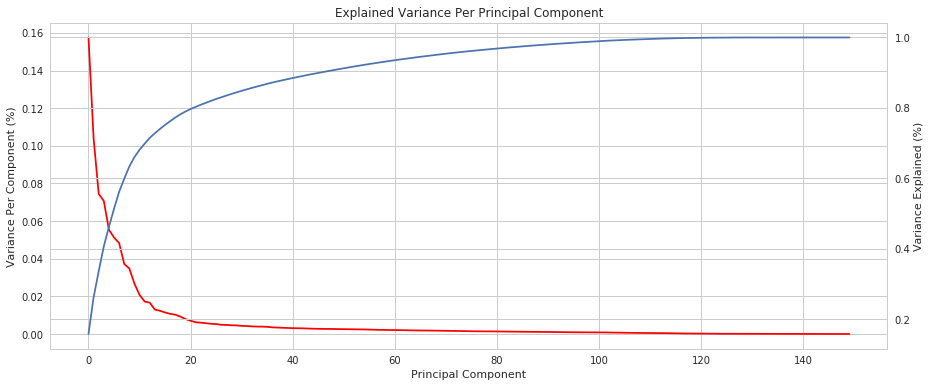

In [105]:
# Investigate the variance accounted for by each principal component.

def plot_pca_variance(pca):
    sns.set_style("whitegrid")
    components = np.arange(len(pca.components_))
    variance = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 6))
    ax = plt.subplot(111)
    cum_var = np.cumsum(variance)
    ax2 = ax.twinx()
    ax.plot(components, variance,color = 'red')
    ax2.plot(components, cum_var)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Per Component (%)")
    ax2.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

plot_pca_variance(pca)

In [118]:
cum_vals=np.cumsum(pca.explained_variance_ratio_)
for i,cumval in enumerate(cum_vals):
    if cumval>0.95:
        break
components_picked=i+1
print(f'Picking {components_picked} components and will explain {round(cum_vals[i]*100,2)}% of the variance')

Picking 69 components and will explain 95.05% of the variance


In [119]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(components_picked)
pca_model= pca.fit(azdias_scaled)
azdias_pca = pca_model.transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

Picking the number of components was quite difficult. Reading up on the subject I found that its quite the open-ended question. There are a few heuristics that can be used. One of the most common ones is plotting a cumulative variance graph and to look at where the elbow is. In my graph, one can see a clear elbow at 18 components which explains 77% variation. One of the other heuristics is to pick the number of principle components which explains 95%-99% of the variance, this method is amore mathematical approach. I'm very tempted to pick the 18 components, but after reading up on the subject of selecting the correct amount of variance it seems that it changes on a case per case basis and relies on the researchers domain knowlage. Since I'm not an expert I would rather use the second method and pick the amount of principle components that explains at least 95% of the variance. I will therefore pick 69 components. PCA therefore helped me to illiminate 79 features from my dataset in order to greatly reduce the dimentionaly for Kmeans. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [120]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def showPrincipleComponant(pca, component, feature_names,fig):
    components_weights=pd.DataFrame(pca.components_, columns = feature_names)
    weights_df=pd.DataFrame(components_weights.loc[component].sort_values(ascending = False)).reset_index().rename(columns={
        'index': 'Feature'})
    drop_feat=list(np.arange(5,len(feature_names)-5))
    bar_dt=weights_df[~weights_df.index.isin(drop_feat)]
    plt.figure(figsize=(15, 6))
    sns.barplot(x = bar_dt.Feature, y = bar_dt[component])
    plt.xticks(rotation=90)
    plt.ylabel('Weight')
    plt.xlabel('Feature')
    plt.title(f'Fig {fig}: Top 5 features vs bottom 5 features for Component {component+1}')
    plt.show()
    print(bar_dt)
    
    return


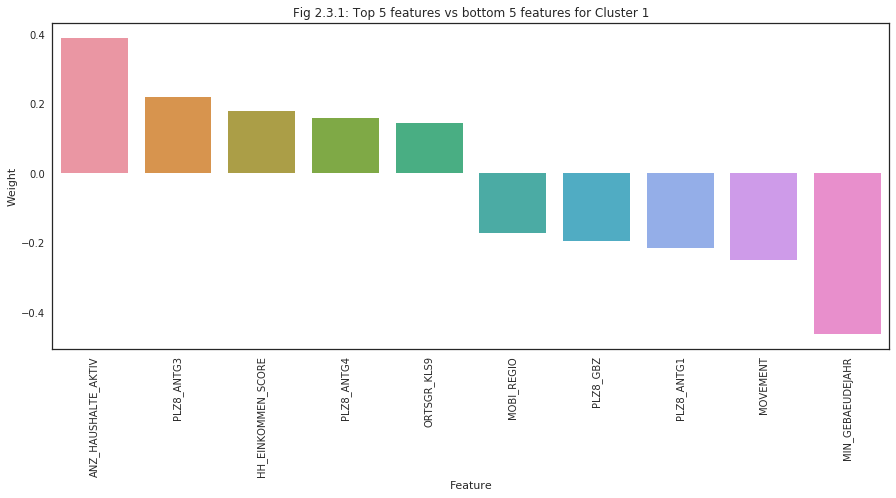

                 Feature         0
0    ANZ_HAUSHALTE_AKTIV  0.390569
1             PLZ8_ANTG3  0.218098
2     HH_EINKOMMEN_SCORE  0.177881
3             PLZ8_ANTG4  0.158551
4            ORTSGR_KLS9  0.144525
145           MOBI_REGIO -0.170934
146             PLZ8_GBZ -0.194576
147           PLZ8_ANTG1 -0.214637
148             MOVEMENT -0.249028
149     MIN_GEBAEUDEJAHR -0.463128


In [151]:
showPrincipleComponant(pca, 0, feature_names,'2.3.1')

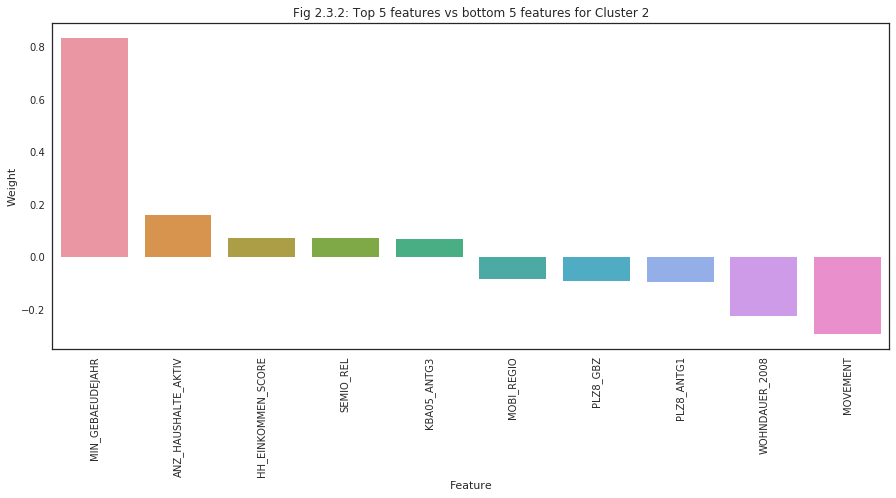

                 Feature         1
0       MIN_GEBAEUDEJAHR  0.834292
1    ANZ_HAUSHALTE_AKTIV  0.158520
2     HH_EINKOMMEN_SCORE  0.073151
3              SEMIO_REL  0.071842
4            KBA05_ANTG3  0.068974
145           MOBI_REGIO -0.085366
146             PLZ8_GBZ -0.093967
147           PLZ8_ANTG1 -0.094546
148       WOHNDAUER_2008 -0.224790
149             MOVEMENT -0.294347


In [152]:
showPrincipleComponant(pca, 1, feature_names,'2.3.2')

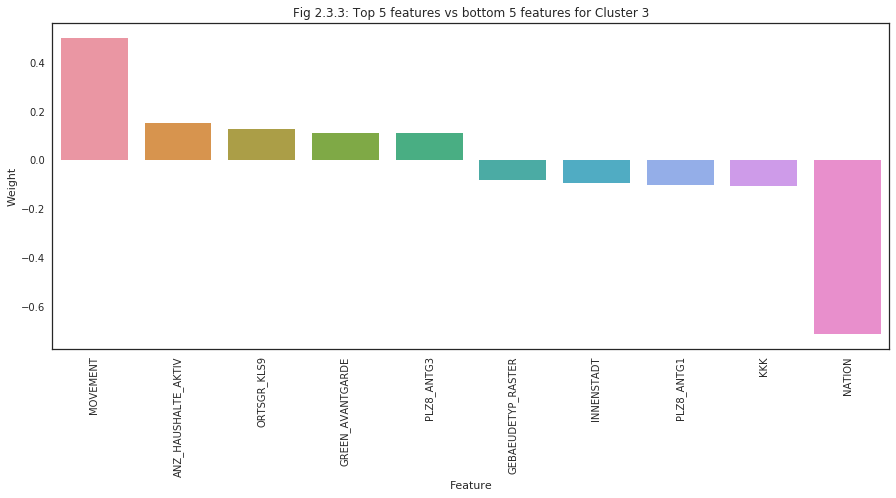

                 Feature         2
0               MOVEMENT  0.500358
1    ANZ_HAUSHALTE_AKTIV  0.152781
2            ORTSGR_KLS9  0.127534
3       GREEN_AVANTGARDE  0.113630
4             PLZ8_ANTG3  0.111608
145   GEBAEUDETYP_RASTER -0.079440
146           INNENSTADT -0.090252
147           PLZ8_ANTG1 -0.100054
148                  KKK -0.106022
149               NATION -0.711042


In [153]:
showPrincipleComponant(pca, 2, feature_names,'2.3.3')

### Discussion 2.3: Interpret Principal Components

**First Component:**

The first principal component increases with increasing ANZ_HAUSHALTE_AKTIV, PLZ8_ANTG3, HH_EINKOMMEN_SCORE, PLZ8_ANTG4 and ORTSGR_KLS9. It also decreases as GEBAEUDETYP_RASTER, PLZ8_GBZ, PLZ8_ANTG1, MOVEMENT, and MIN_GEBAEUDEJAHR increases. For instance, communities with high values will have a high number of households in the building and older first year that the building was mentioned in the database.

_Top 5 Features_
- ANZ_HAUSHALTE_AKTIV: Number of households in the building
- PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region
- HH_EINKOMMEN_SCORE: Estimated household net income
- PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region
- ORTSGR_KLS9: Size of community

_Bottom 5 Features_
- GEBAEUDETYP_RASTER: Ratio of residential to commercial activity
- PLZ8_GBZ: Number of households within the PLZ8 region
- PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region
- MOVEMENT: MOVEMENT-Mainstream
- MIN_GEBAEUDEJAHR: First-year building was mentioned in the database

**Second Component**

The second principal component increases with increasing MIN_GEBAEUDEJAHR, ANZ_HAUSHALTE_AKTIV, HH_EINKOMMEN_SCORE, SEMIO_REL and KBA05_ANTG3. It also decreases as MOBI_REGIO, PLZ8_GBZ, SEMIO_PFLICHT, WOHNDAUER_2008 and MOVEMENT increases. For instance, communities with high values will have a newer first year that the building was mentioned in the database and will have more Mainstream people.

_Top 5 Features_
- MIN_GEBAEUDEJAHR: First-year building was mentioned in the database
- ANZ_HAUSHALTE_AKTIV: Number of households in the building
- HH_EINKOMMEN_SCORE: Estimated household net income
- SEMIO_REL: Personality typology, religious
- KBA05_ANTG3: Number of 3-5 family houses in the microcell

_Bottom 5 Features_
- MOBI_REGIO: Movement patterns
- PLZ8_GBZ: Number of buildings within the PLZ8 region
- SEMIO_PFLICHT: Personality typology, dutiful
- WOHNDAUER_2008: Length of residence
- MOVEMENT: Mainstream or Avantgarde

**Third Component**

The third principal component increases with increasing MOVEMENT, ANZ_HAUSHALTE_AKTIV, ORTSGR_KLS9, GREEN_AVANTGARDE, and PLZ8_ANTG3. It also decreases as GEBAEUDETYP_RASTER, INNENSTADT, PLZ8_ANTG1, KKK and NATION increases. For instance, communities with high values will have more Avantgarde people and more east nation people.

_Top 5 Features_
- MOVEMENT: Mainstream or Avantgarde
- ANZ_HAUSHALTE_AKTIV: Number of households in the building
- ORTSGR_KLS9: Size of community
- GREEN_AVANTGARDE: Membership in environmental sustainability as part of youth
- PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region

_Bottom 5 Features_
- GEBAEUDETYP_RASTER: Ratio of residential to commercial activity
- INNENSTADT: Distance to the city center (downtown)
- PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region
- KKK: Purchasing power in the region
- NATION: East Or West Nation

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [135]:
# Over a number of different cluster counts...
def gen_kmeans_score(data, center):
    start_time = time.time()
    kmeans = KMeans(center, random_state=42)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    runtime=np.round(((time.time() - start_time)/60),2)
    print(f'Score: {score}\n Runtime: {runtime}mins')
    return score

In [136]:
centeroid=np.arange(3,31,3)
scoreL=[]
for i in centeroid:
    scoreL.append(gen_kmeans_score(azdias_pca, i))       

Score: 34365284.79718583
 Runtime: 0.95mins
Score: 28906596.20587059
 Runtime: 1.86mins
Score: 26517309.320216347
 Runtime: 2.3mins
Score: 25118440.45026685
 Runtime: 4.34mins
Score: 24111922.420165475
 Runtime: 4.46mins
Score: 23467221.830281835
 Runtime: 5.88mins
Score: 22848266.665725444
 Runtime: 7.84mins
Score: 22359388.797334295
 Runtime: 7.89mins
Score: 21981935.676121965
 Runtime: 10.96mins
Score: 21567929.811837677
 Runtime: 11.75mins


In [196]:
diff=[]
for i in range(1,len(scoreL)):
    diff.append(scoreL[i-1]-scoreL[i])

<a id='fig3_1'></a>

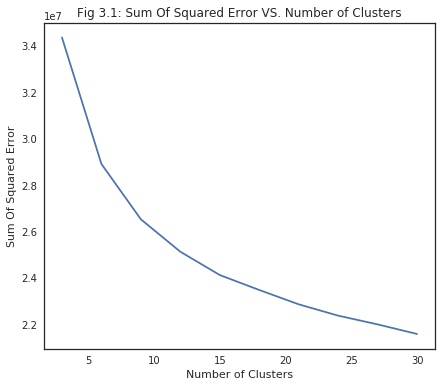

In [143]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
sns.set_style("white")
plt.figure(figsize=(7, 6))
plt.plot(centeroid, scoreL)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum Of Squared Error')
plt.title('Fig 3.1: Sum Of Squared Error VS. Number of Clusters')
plt.show()

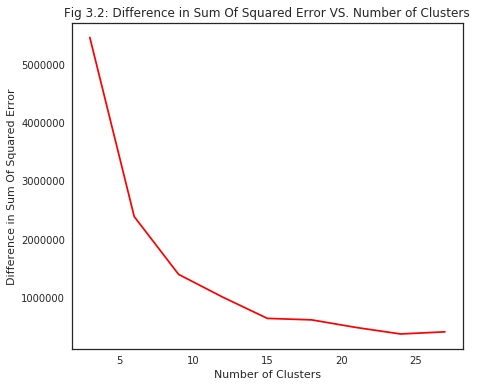

In [191]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
sns.set_style("white")
plt.figure(figsize=(7, 6))
plt.plot(centeroid[:-1], diff, color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Difference in Sum Of Squared Error')
plt.title('Fig 3.2: Difference in Sum Of Squared Error VS. Number of Clusters')
plt.show()

In [192]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=15, random_state=42)
kmeans_model = kmeans.fit(azdias_pca)
kmeans_predictions = kmeans_model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

I plotted [Fig 3.1](#fig3_1) and [Fig 3.2](#fig3_2) (just to show the change in SSE in order to better visualize the "elbow") in order to choose the number of clusters. Here one can see the sum of squared error vs the number of clusters. It seems that 15 would be the correct number of clusters when using the elbow method. I will, therefore, pick 15 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [193]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

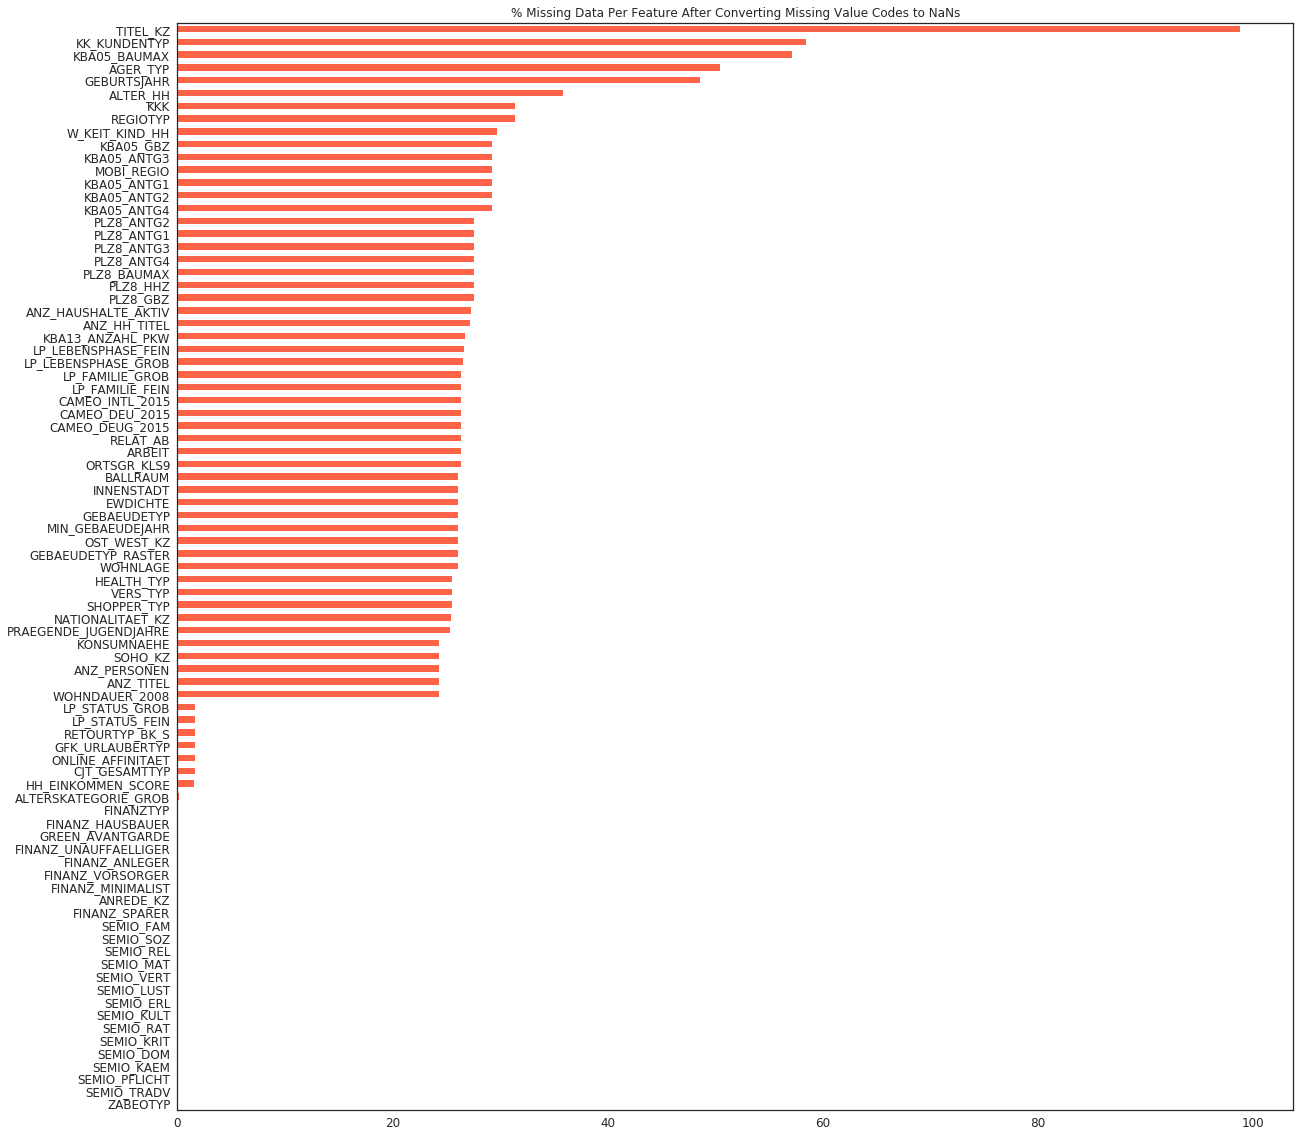

In [194]:
customers=replace_missing(customers,feat_info_t)
Percentage_of_Null_Per_Column=customers.isnull().sum() * 100 / len(customers)
Percentage_of_Null_Per_Column.sort_values().plot.barh(figsize=(20,20),fontsize=12,color='tomato')
plt.title('% Missing Data Per Feature After Converting Missing Value Codes to NaNs')
plt.show()

In [195]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [200]:
customers,_ = clean_data(customers, feat_info_t,Col_keepL)

In [201]:
customers.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MOVEMENT,NATION,WEALTH,LIFE_STAGE,RURAL
count,138856.000000,139068.000000,139068.000000,139068.000000,139068.000000,139068.000000,139068.000000,139068.000000,139068.000000,136957.000000,...,139068.000000,139068.000000,139068.000000,139068.000000,139068.000000,138033.000000,138033.000000,138792.000000,138792.000000,139068.000000
mean,3.493130,1.330177,4.267891,1.423663,4.570591,1.596945,1.845795,2.742939,0.501625,1.966004,...,0.081507,0.132877,0.074625,0.092573,0.045043,1.505386,2.779306,2.597289,3.370403,0.237445
std,0.724651,0.470278,1.017478,0.826490,0.838004,0.998658,0.964908,1.314828,0.499999,0.772332,...,0.273613,0.339443,0.262787,0.289835,0.207399,0.499973,0.450053,1.406275,1.339537,0.425519
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,3.000000,1.000000,4.000000,1.000000,4.000000,1.000000,1.000000,2.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,2.000000,0.000000
50%,4.000000,1.000000,5.000000,1.000000,5.000000,1.000000,2.000000,2.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,2.000000,4.000000,0.000000
75%,4.000000,2.000000,5.000000,2.000000,5.000000,2.000000,2.000000,4.000000,1.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,4.000000,4.000000,0.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,5.000000,5.000000,1.000000


In [212]:
set(list(azdias))-set(list(customers))

{'GEBAEUDETYP_5'}

In [207]:
feat_info_t.loc[feat_info_t.attribute=='GEBAEUDETYP']

,attribute,information_level,type,missing_or_unknown
52,GEBAEUDETYP,building,categorical,"[-1,0]"


Here we can see that there was one value that wasn't in the catagorical feature GEBAEUDETYP from our customers dataset that was in our general population dataset. So I'm now going to create this variable in my customer dataset and use nan values so it can be imputed.

In [216]:
customers['GEBAEUDETYP_5']=np.nan

In [259]:
customers_imputed = imputer.transform(customers)
customers_scaled = pd.DataFrame(scalar_model.transform(customers_imputed), columns = feature_names)

In [260]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_pca = pca.transform(customers_scaled)

In [261]:
predict_customers =kmeans_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [262]:
data={'pred':[],'pop':[],'cluster':[]}
difference=[]
for i in range(0,15):
    gen_pop=(kmeans_predictions==i).sum()*100/len(kmeans_predictions)
    client_pop=(predict_customers==i).sum()*100/len(predict_customers)
    data['pred'].append(gen_pop)
    data['pop'].append('General Population')
    data['cluster'].append(i+1)
    data['pred'].append(client_pop)
    data['pop'].append('Customer Population')
    data['cluster'].append(i+1)
    difference.append(client_pop-gen_pop)
cluster_perc_df=pd.DataFrame(data)
cluster_perc_df

,cluster,pop,pred
0,1,General Population,6.053300
1,1,Customer Population,0.109299
2,2,General Population,10.117118
3,2,Customer Population,0.274686
4,3,General Population,8.162245
5,3,Customer Population,0.350188
6,4,General Population,3.277947
7,4,Customer Population,0.941985
8,5,General Population,7.911525
9,5,Customer Population,0.368165


<a id='fig3_3_1'></a>

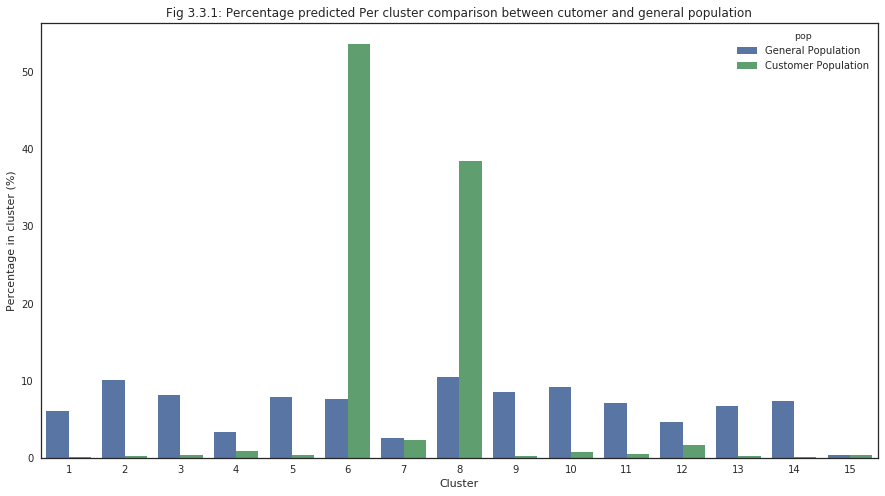

In [263]:
plt.figure(figsize=(15, 8))
ax = sns.barplot(x="cluster", y="pred", hue="pop", data=cluster_perc_df)
plt.xlabel('Cluster')
plt.ylabel('Percentage in cluster (%)')
plt.title('Fig 3.3.1: Percentage predicted Per cluster comparison between cutomer and general population')
plt.show()

In [264]:
kmeans.cluster_centers_[5]

array([ -2.52054883e+00,  -2.55162847e+00,   3.72370558e+00,
         3.81484012e-01,   3.37985807e-01,  -2.00008836e-01,
        -6.65178509e-01,   5.05314309e-02,  -2.60856391e-02,
        -4.62194177e-02,  -1.71671093e-01,  -1.84568027e-02,
         2.33231735e-01,  -4.65350390e-03,   4.41907990e-02,
        -2.80135345e-02,   3.25544008e-02,  -1.28638515e-02,
        -3.86552100e-02,   6.23737912e-02,   2.58123337e-02,
        -1.04866348e-01,   5.53201441e-02,  -4.80547267e-02,
         1.40524504e-02,   3.90887879e-02,   2.38484373e-03,
        -3.68076619e-02,   4.80199011e-02,   3.90190529e-02,
         3.04720990e-02,  -2.06520728e-02,   1.22070504e-02,
        -3.22864482e-02,  -1.91604658e-02,  -2.63170591e-02,
         2.54590178e-02,   7.34582798e-03,   7.94277106e-03,
         3.87760370e-03,   1.06404730e-02,   1.11208564e-02,
         4.43878830e-02,  -4.27338513e-02,   6.99380752e-03,
        -1.18097724e-02,  -1.23911348e-03,  -5.61356572e-02,
         2.91843152e-04,

In [251]:
len(kmeans.labels_)

780153

<a id='fig3_3_2'></a>

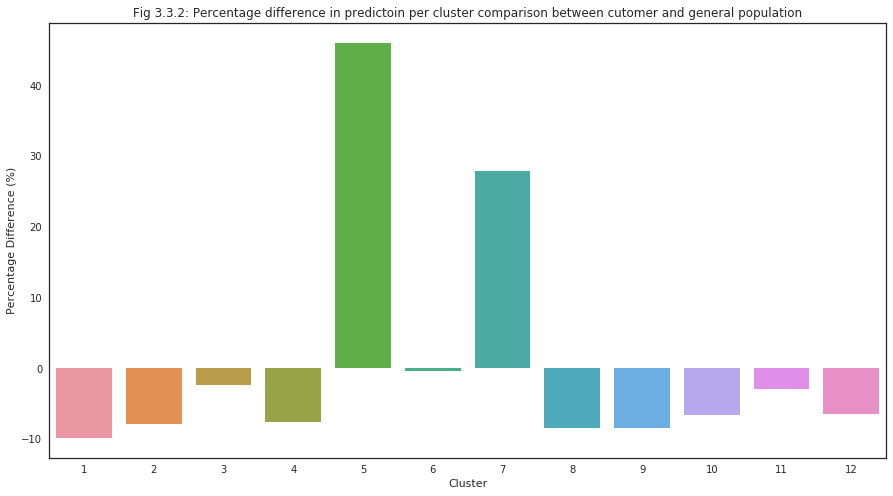

In [223]:
difference
plt.figure(figsize=(15, 8))
sns.barplot(x=np.arange(1,13,1), y=difference)
plt.xlabel('Cluster')
plt.ylabel('Percentage Difference (%)')
plt.title('Fig 3.3.2: Percentage difference in predictoin per cluster comparison between cutomer and general population')
plt.show()

In [359]:
overrepresentedCluster=np.argmax(difference)
underrepresentedCluster=np.argmin(difference)

In [373]:
def displayCluster(pca,feature_names,kmeans,cluster,fig):    
    cluster_data={'features':feature_names,'component_weights':list(pca.inverse_transform(kmeans.cluster_centers_[cluster-1]))}
    clusterDF=pd.DataFrame.from_dict(cluster_data).sort_values(by='component_weights',ascending = False).reset_index()
    bar_dt=clusterDF[~clusterDF.index.isin(clusterDF.features[5:-5].index)]
    plt.figure(figsize=(15, 6))
    sns.barplot(x = bar_dt.features, y = bar_dt.component_weights)
    plt.xticks(rotation=90)
    plt.ylabel('Weight')
    plt.xlabel('Feature')
    plt.title(f'Fig {fig}: Top 5 features vs bottom 5 features for Cluster {cluster}')
    plt.show()
    print(bar_dt)

<a id='fig3_3_3'></a>

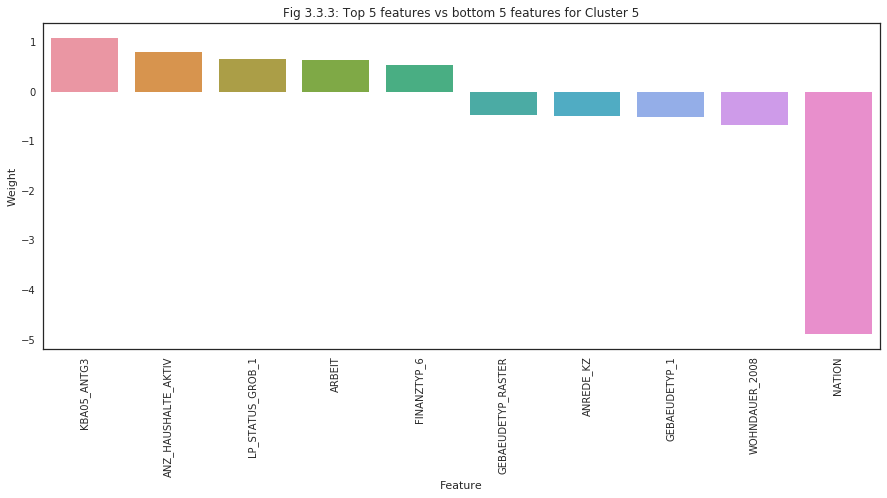

     index  component_weights             features
0       40           1.081307          KBA05_ANTG3
1       32           0.802417  ANZ_HAUSHALTE_AKTIV
2      111           0.659673     LP_STATUS_GROB_1
3       58           0.637625               ARBEIT
4       72           0.528623          FINANZTYP_6
145     46          -0.475279   GEBAEUDETYP_RASTER
146      1          -0.491248            ANREDE_KZ
147    129          -0.521810        GEBAEUDETYP_1
148     31          -0.666098       WOHNDAUER_2008
149    146          -4.899356               NATION


In [374]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
displayCluster(pca,feature_names,kmeans,overrepresentedCluster,'3.3.3')

<a id='fig3_3_4'></a>

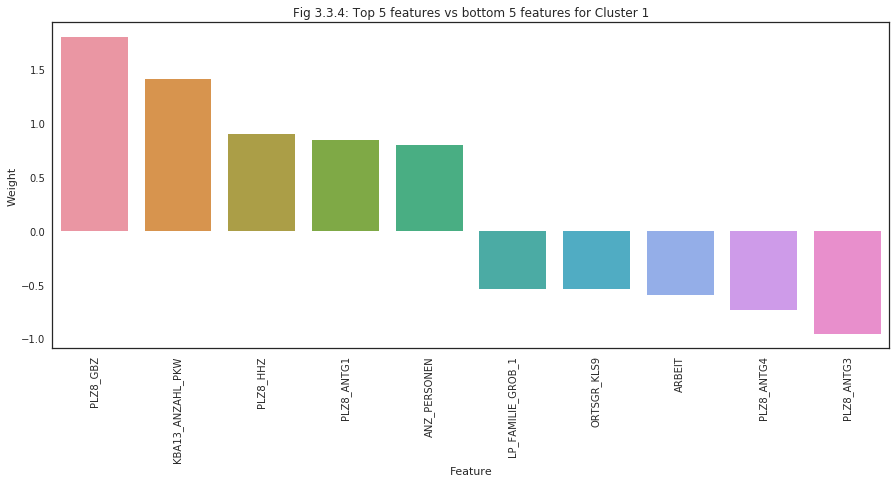

     index  component_weights           features
0       57           1.798311           PLZ8_GBZ
1       51           1.407205   KBA13_ANZAHL_PKW
2       56           0.894194           PLZ8_HHZ
3       52           0.845550         PLZ8_ANTG1
4       27           0.792571       ANZ_PERSONEN
145     96          -0.540196  LP_FAMILIE_GROB_1
146     59          -0.541670        ORTSGR_KLS9
147     58          -0.592288             ARBEIT
148     55          -0.733322         PLZ8_ANTG4
149     54          -0.954252         PLZ8_ANTG3


In [367]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
displayCluster(pca,feature_names,kmeans,underrepresentedCluster,'3.3.4')

### Discussion 3.3: Compare Customer Data to Demographics Data

In [Fig 3.3.1](#fig3_3_1) one can see a comparison of percentage predicted per cluster which also compares the general public dataset to the customer data set. Here we can see that there is a clear overrepresented cluster of data for that customer data. This is very good since this shows that kmeans identified a customer segment which the mail orders company can target. One can also see that there is a clear underrepresented clusters which means that we can also advise the mail orders company which customers segment they should avoid. In [Fig 3.3.2](#fig3_3_2) one can also see the difference between the customer dataset and general population dataset. 

_Over Represented Cluster_

In [Fig 3.3.2](#fig3_3_2) we can see that cluster 5 is clearly Overrepresented in the data. We can, therefore, assume that the customers in this cluster will have a much higher probability to make use of the sales compony's services. 

Based on [Fig 3.3.3](#fig3_3_3) we can say the following about the mail orders company's client base per feature:
1. KBA05_ANTG3: They have a high share of 6-10 family homes in the microcell.
2. ANZ_HAUSHALTE_AKTIV: They have a high number of households in the building
3. LP_STATUS_GROB_1: They have a social status of low-income earners.
4. ARBEIT: Their share of unemployment in the community is on the high end.
5. FINANZTYP_6: Their financial type is inconspicuous
6. GEBAEUDETYP_RASTER: Their ratio of residential to commercial activity is business cell.
7. ANREDE_KZ: Their gender is male.
8. GEBAEUDETYP_1: Their building type is residential
9. WOHNDAUER_2008: Their length of residence is pretty short.
10. NATION: Their Nation is East.

_Underrepresented Cluster_
Based on [Fig 3.3.4](#fig3_3_4) we can say the following the mail order company's client base per feature:
1. PLZ8_GBZ  : They have a lower number of buildings in the PLZ8 region than the general population.
2. KBA13_ANZAHL_PKW  : They have a lower number of cars in the PLZ8 region than the general population.
3. PLZ8_HHZ  : They have a lower number of households within the PLZ8 region than the general population.
4. PLZ8_ANTG1  : They have no to low share of 1-2 family homes within the PLZ8 region than the general population.
5. ANZ_PERSONEN  : They have a lower number of adults in the household than the general population.

_Bottom 5 Features_
6. LP_FAMILIE_GROB_1 : Their family tipe is less likely to be single than the general population.
7. ORTSGR_KLS9 : Their size of the community is less likely to be small than the general population.
8. ARBEIT : Their share of unemployment in the community is less likely to be low compared to the general population.
9. PLZ8_ANTG4 : Their share of 10+ family homes in the PLZ8 region is less likely to be low compared to the general population.
10. PLZ8_ANTG3 : Their share of 6-10 family homes in the PLZ8 region is less likely to be low compared to the general population.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.